In [16]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from labdata.schema import * 

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
#matplotlib.rcParams.update({'font.size': 16})

In [17]:
SAVEPATH = Path(r'/home/mmelin/chronic_manuscript_figures')
SUBJECTS = ['MM009','MM010','MM011']
SESSIONS = ['2023-10-16/001', # #TODO: change back to 10-17
            '2023-10-25/001',
            '2023-11-21/001'] # TODO 2023-11-28/001 was used originally, but needs to be sorted  

KILOSORT_PARAMETER_SET_NUM = 5
CRITERIA_ID = 1

labels = ['Reimplant 1','Reimplant 2','Reimplant 3']

base_query = UnitCount.Unit * UnitMetrics * EphysRecording.ProbeSetting()

There are 545 total units for MM009 on 2023-10-16/001
There are 85 single units for MM009 on 2023-10-16/001
There are 638 total units for MM010 on 2023-10-25/001
There are 127 single units for MM010 on 2023-10-25/001
There are 672 total units for MM011 on 2023-11-21/001
There are 122 single units for MM011 on 2023-11-21/001


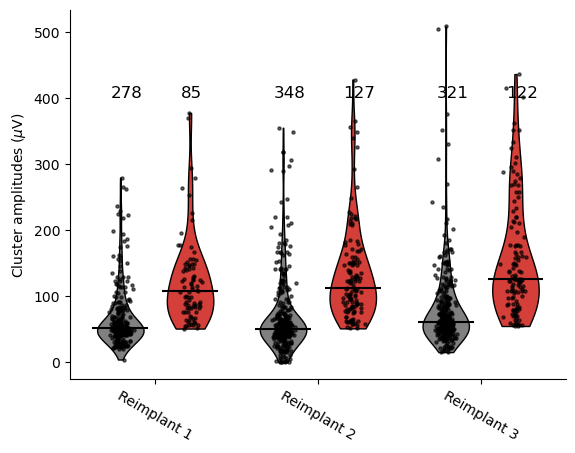

In [18]:
fig, ax = plt.subplots()
fdict = {'fontsize': 12}
x = 0
xvals = []
for i,(sname,sdate) in enumerate(zip(SUBJECTS, SESSIONS)):
    query_dict = dict(parameter_set_num=KILOSORT_PARAMETER_SET_NUM,
                      unit_criteria_id=CRITERIA_ID,
                      subject_name=sname,
                      session_name=sdate)
    units = base_query & query_dict
    print(f'There are {len(units)} total units for {sname} on {sdate}')
    print(f'There are {np.sum(units.fetch("passes"))} single units for {sname} on {sdate}')
    passing, amps = units.fetch('passes','spike_amplitude')
    passing = passing[amps > 0]
    amps = amps[amps > 0]
    su_amps = amps[passing==1]
    mu_amps = amps[passing==0]

    # plotting
    scatter_positions = np.random.normal(x, scale=.05, size=len(mu_amps))
    parts = plt.violinplot([mu_amps],[x], showmedians=False, showextrema=False, showmeans=False)
    plt.scatter(scatter_positions, mu_amps, s=5, color='black', alpha=.6)
    plt.hlines(np.median(mu_amps), x-.3, x+.3, color='black')
    plt.text(x-.1,400,f'{len(mu_amps)}',fontdict=fdict)
    for pc in parts['bodies']:
        pc.set_facecolor('grey')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    xvals.append(x)
    x += .75

    scatter_positions = np.random.normal(x, scale=.05, size=len(su_amps))
    parts = plt.violinplot([su_amps],[x], showmedians=False, showextrema=False, showmeans=False)
    plt.scatter(scatter_positions, su_amps, s=5, color='black', alpha=.6)
    plt.hlines(np.median(su_amps), x-.3, x+.3, color='black')
    plt.text(x-.1,400,f'{len(su_amps)}',fontdict=fdict)
    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    xvals.append(x)
    x += 1
xvals = [np.mean([xvals[i],xvals[i+1]]) for i in range(0,len(xvals),2)]
plt.xticks(xvals, labels)
plt.xticks(rotation=-30)
plt.ylabel('Cluster amplitudes ($\mu$V)')
plt.xlabel('')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.savefig(SAVEPATH / 'reimplant_amplitudes.pdf', format='pdf', dpi=500, bbox_inches='tight')

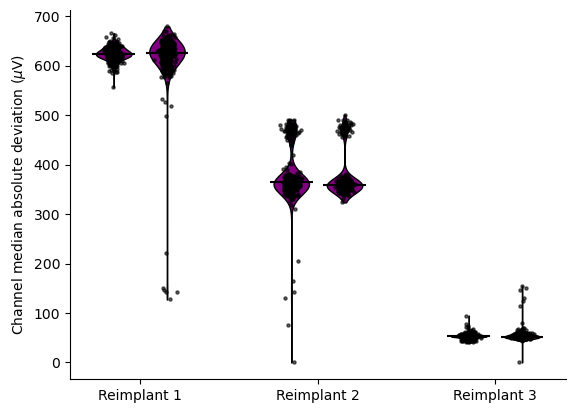

In [19]:
# now let's plot noise stats
x = 0
xvals = []
for i,(sname,sdate) in enumerate(zip(SUBJECTS, SESSIONS)):
    query_dict = dict(subject_name=sname,
                      session_name=sdate)
    noise_stats = EphysRecordingNoiseStats() & query_dict
    mads = noise_stats.fetch('channel_mad')
    for probe_mads in mads:
        probe_mads = probe_mads[:,0]
        scatter_positions = np.random.normal(x, scale=.05, size=len(probe_mads))
        parts = plt.violinplot([probe_mads],[x], showmedians=False, showextrema=False, showmeans=False)
        for pc in parts['bodies']:
            pc.set_facecolor('purple')
            pc.set_edgecolor('black')
            pc.set_alpha(1)
        plt.scatter(scatter_positions, probe_mads, s=5, color='black', alpha=.6)
        plt.hlines(np.median(probe_mads), x-.3, x+.3, color='black')
        xvals.append(x)
        x += .75
    x += 1
plt.ylabel('Channel median absolute deviation ($\mu$V)')
plt.gca().spines[['right', 'top']].set_visible(False)

xvals = [np.mean([xvals[i],xvals[i+1]]) for i in range(0,len(xvals),2)]
plt.xticks(xvals, labels)
plt.show()
        

In [20]:
for i,(sname,sdate) in enumerate(zip(SUBJECTS, SESSIONS)):
    query_dict = dict(subject_name=sname,
                      session_name=sdate)
    f = EphysRecordingNoiseStats  & query_dict
f

subject_name unique mouse id,session_name session identifier,dataset_name,probe_num probe number,"channel_median nchannels*2 array, the 1st column is the start, 2nd at the end of the file",channel_max,channel_min,channel_peak_to_peak,channel_mad median absolute deviation
MM011,2023-11-21/001,raw_ephys_data,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
MM011,2023-11-21/001,raw_ephys_data,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
